In [9]:
from pp_functions import *
from shapely.ops import unary_union
from affine import Affine
import numpy as np

import xarray as xr
import rioxarray
from datetime import datetime

In [10]:
# Define Basin, Model Run, Year
name = 'BUDD'
model = 'base'
year = 2022
starting_value = 0
utm_epsg = 'EPSG:32611'
# utm_epsg = 'EPSG:26913'

# Define filepaths and directories
# mask filepaths
BS = f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson'
basin_buff_fn = f'/home/etboud/projects/data/masks/{name}_mask_buffered.tif'
basin_fn = f'/home/etboud/projects/data/masks/{name}_mask.tif'
rgi = '/home/etboud/projects/data/RGI/02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp'
wbd = '/home/etboud/projects/data/masks/NHDWaterbody.shp'
can = f'/home/etboud/projects/data/masks/4b_15img_ndvi_30_85_{name}_notclipped.tif'
# raw PS images
ps_raw = f'/data0/images/planet/emma/planet/{name}/'
# Processed PS SCA
ps_sca_dir = f'/data0/images/planet/emma/planet/raw_snow_maps/{name}/{model}/'


# Read in masks
basin = gpd.read_file(BS).to_crs(utm_epsg)
basin_buff_mask = rxr.open_rasterio(basin_buff_fn)
rgi_mask = gpd.read_file(rgi).to_crs(utm_epsg)
wbd_mask = gpd.read_file(wbd).to_crs(utm_epsg)
invalid_area = unary_union(rgi_mask.geometry.values.tolist() + wbd_mask.geometry.values.tolist())
ndvi_mask = rxr.open_rasterio(can)
ndvi_mask.values = np.where(ndvi_mask.values>0, 0, 1)

# Get directories
ps_raw_subdir = sorted([d for d in glob.glob(ps_raw + str(year) + '*') if os.path.isdir(d)])
ps_sca_tif = glob.glob(ps_sca_dir + f'*{year}*.tif')


In [11]:
# Load the reference GeoTIFF with ideal output projection and resolution
with rio.open(f'/home/etboud/projects/data/masks/{name}_mask.tif') as ref:
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_width = ref.width
    ref_height = ref.height

### stacking aso

In [ ]:
corr_files = pd.read_csv('/home/etboud/projects/snow_mapping/COPP_corresponding_files.csv') #/home/etboud/projects/snow_mapping/corresponding_files_all.csv
corr_files
# corr_yr_files = corr_files[(corr_files['model_run']=='V5')&(corr_files['model_file'].split('/')[-3]==name)]
# Apply split to each 'model_file' entry and filter based on 'model_run' and the extracted name
corr_yr_files = corr_files[
    (corr_files['model_run'] == 'V5') & 
    (corr_files['model_file'].apply(lambda x: x.split('/')[-3] == name))
]
corr_yr_files.drop_duplicates(subset='aso_date', keep='last',inplace=True)
# corr_yr_files = corr_files[corr_files['aso_date'].astype(str).str[:4]== str(year)]

aso_list = []
date_list = []
for index, row in corr_yr_files.iterrows():
    print(row['aso_file'])
    aso_data = rxr.open_rasterio(row['aso_file'],masked=True)
    aso_data.values = np.where(np.isnan(aso_data.values), 0, aso_data.values)
    aso_data = aso_data.rio.clip(basin.geometry, drop=False)
    aso_data = aso_data.rio.clip(rgi_mask.geometry, invert=True)
    aso_data = aso_data.rio.clip(wbd_mask.geometry, invert=True)
    # plot aso_data
    aso_data.plot()
    date = row['aso_date']
    date_list.append(date)
    aso_list.append(aso_data.squeeze().values)
    
# Create a stacked data array for ASO snow cover
stacked_data = np.stack(aso_list, axis=0).astype(float)
# Make an array of the dates
dates = np.array(date_list)
dates = pd.to_datetime(dates, format='%Y-%m-%d')
# Step 2: Ensure dates are properly formatted and used as time coordinates
# No need to stack dates as floats; they will be used directly as time coordinates

# Step 3: Generate real-world coordinate arrays from ref_transform
x_coords = np.arange(ref_width) * ref_transform.a + ref_transform.c
y_coords = np.arange(ref_height) * ref_transform.e + ref_transform.f
# if ref_transform.e < 0:
#     y_coords = y_coords[::-1]

# Step 4: Build the DataArray with real coordinates
xr_data = xr.DataArray(
    stacked_data,
    dims=['time', 'y', 'x'],
    coords={'time': dates, 'y': y_coords, 'x': x_coords}
)

# Step 5: Assign CRS and transform directly
xr_data = xr_data.rio.write_crs(ref_crs)
xr_data = xr_data.rio.write_transform(ref_transform)
xr_data.name = "data"
# Step 6: Save to NetCDF
xr_data.to_netcdf(f'/home/etboud/projects/data/stacks/{name}_aso_projected.nc', format='NETCDF4')

### Stacking model outputs

In [4]:
valid_area = unary_union(basin.geometry.values)
final_geometry = valid_area.difference(invalid_area)
# Step 1: Build your data stack (clipped_data should be the same size as BUDD_mask)
dates_list = []
data_list = []

for file in sorted(ps_sca_tif):
    date = np.datetime64(datetime.strptime(os.path.basename(file).split('_')[0], '%Y%m%d'))
    dates_list.append(date)

    data = rxr.open_rasterio(file, drop=True, chunks = True, masked=True).squeeze('band', drop=True)
    data = data.fillna(0)
    data = data.rio.clip([final_geometry], basin.crs)
    # Optional: assert shape matches reference
    assert data.shape == (ref_height, ref_width), f"Shape mismatch: {data.shape}"

    data_list.append(data.values)  # get raw values for stacking

# Step 2: Stack the data
stacked_data = np.stack(data_list, axis=0).astype(float)

# Step 3: Generate real-world coordinate arrays from ref_transform
x_coords = np.arange(ref_width) * ref_transform.a + ref_transform.c
y_coords = np.arange(ref_height) * ref_transform.e + ref_transform.f
# if ref_transform.e < 0:
#     y_coords = y_coords[::-1]

# Step 4: Build the DataArray with real coordinates
xr_data = xr.DataArray(
    stacked_data,
    dims=['time', 'y', 'x'],
    coords={'time': dates_list, 'y': y_coords, 'x': x_coords}
)

# Step 5: Assign CRS and transform directly
xr_data = xr_data.rio.write_crs(ref_crs)
xr_data = xr_data.rio.write_transform(ref_transform)
xr_data.name = "data"
# Step 6: Save to NetCDF
xr_data.to_netcdf(f'/home/etboud/projects/data/stacks/{name}_{model}_{year}_projected.nc', format='NETCDF4')

### Temporal post-processing

In [5]:
# Looping through snow maps and applying temporal post processing
files = sorted(glob.glob(ps_sca_dir + f'*{year}*SCA.tif'))[starting_value:] 

# Initialize
ref_date = datetime(year - 1, 10, 1).date()
dates_list = []
data_list = []

# Loop through the good planet scenes
for fCount, file in enumerate(files):
    date = np.datetime64(datetime.strptime(os.path.basename(file).split('_')[0], '%Y%m%d'))
    dates_list.append(date)
    data = rxr.open_rasterio(file, drop=True, chunks = True, masked=True).squeeze('band', drop=True)
    data= data.fillna(0)
    data = data.rio.clip([invalid_area], invert=True) #testing
    data_list.append(data.squeeze())

stacked_data = np.stack(data_list, axis=0).astype(float)
nodata_ref = stacked_data.copy()
stacked_data = fill_nodata(stacked_data)
# Performing temporal QAQC
resulting_data = qaqc_temp(stacked_data = stacked_data, 
                                            chm_mask =ndvi_mask, 
                                            basin_mask = basin_buff_mask[0], 
                                            buff_raster_fn = basin_buff_fn,
                                            small_raster_fn = basin_fn)

# projecting the post processed arrays
assert resulting_data.shape[-2:] == (ref_height, ref_width), "Data shape doesn't match GeoTIFF shape."
x_coords = np.arange(ref_width) * ref_transform.a + ref_transform.c
y_coords = np.arange(ref_height) * ref_transform.e + ref_transform.f
xr_data = xr.DataArray(
    resulting_data,
    dims=['time', 'y', 'x'],
    coords={'time': dates_list, 'y': y_coords, 'x': x_coords}
)
xr_data = xr_data.rio.write_crs(ref_crs)
xr_data = xr_data.rio.write_transform(ref_transform)
xr_data.name = "data"
# Saving stacked data to netcdf
xr_data.to_netcdf(f'/home/etboud/projects/data/stacks/{name}_{model}T_{year}_QAQC_temporal.nc',format='NETCDF4')

Buffered Raster Bounds: BoundingBox(left=290466.0, bottom=4195185.0, right=298614.0, top=4202463.0)
Smaller Raster Bounds: BoundingBox(left=290562.0, bottom=4195284.0, right=298512.0, top=4202367.0)
final data checks ...


## Spatial post-processing

In [ ]:
# looping through snow maps and applying spatial and temporal post processing
files = sorted(glob.glob(ps_sca_dir + f'*{year}*SCA.tif'))[starting_value:]

# Loop through threshold and radius combinations
thresholds = [.3]
radii = [3]
# Initialize
ref_date = datetime(year - 1, 10, 1).date()

dates_list = []
data_list = []
x_coords = np.arange(ref_width) * ref_transform.a + ref_transform.c
y_coords = np.arange(ref_height) * ref_transform.e + ref_transform.f

# Loop through the good planet scenes
for fCount, file in enumerate(files):
    date = np.datetime64(datetime.strptime(os.path.basename(file).split('_')[0], '%Y%m%d'))
    dates_list.append(date)
    data = rxr.open_rasterio(file, drop=True, chunks = True, masked=True,crs = ref_crs).squeeze('band', drop=True)
    if data.rio.crs != ref_crs:
        data = data.rio.reproject(ref_crs)
    data= data.fillna(0)
    data = data.rio.clip([invalid_area], invert=True) #testing
    data_list.append(data.values)
    
for threshold_percent in thresholds:
    for radius in radii:

        stacked_data = np.stack(data_list, axis=0).astype(float)
        nodata_ref = stacked_data.copy()
        stacked_data = fill_nodata(stacked_data)
        # Perform spatial and temporal QA/QC on stacked data with the canopy mask
        resulting_data = qaqc_spatial(stacked_data = stacked_data, 
                                            chm_mask =ndvi_mask, 
                                            radius = radius, 
                                            threshold_percent = threshold_percent, 
                                            basin_mask = basin_buff_mask[0], 
                                            buff_raster_fn = basin_buff_fn,
                                            small_raster_fn = basin_fn)
        print(resulting_data.shape)


        xr_data = xr.DataArray(
            resulting_data,
            dims=['time', 'y', 'x'],
            coords={'time': dates_list, 'y': y_coords, 'x': x_coords}
        )
        xr_data = xr_data.rio.write_crs(ref_crs)
        xr_data = xr_data.rio.write_transform(ref_transform)
        xr_data.name = "data"
        percent = round(threshold_percent*100)
        # Save the resulting data to a NetCDF file
        xr_data.to_netcdf(f'/home/etboud/projects/data/stacks/{name}_{model}S_{year}_{radius}_{percent}_NDVI_QAQC_spatial_test.nc', format='NETCDF4')

        print(f"Processed and saved file for threshold: {threshold_percent}, radius: {radius}")

In [12]:
# looping through snow maps and applying spatial and temporal post processing
files = sorted(glob.glob(ps_sca_dir + f'*{year}*SCA.tif'))[starting_value:]

# Loop through threshold and radius combinations
thresholds = [.9]
radii = [1,3,5]
# Initialize
ref_date = datetime(year - 1, 10, 1).date()
dates_list = []
data_list = []

for threshold_percent in thresholds:
    for radius in radii:
        dates_list = []
        data_list = []
        # Loop through the good planet scenes
        for fCount, file in enumerate(files):
            date = np.datetime64(datetime.strptime(os.path.basename(file).split('_')[0], '%Y%m%d'))
            dates_list.append(date)
            data = rxr.open_rasterio(file, drop=True, chunks = True, masked=True,crs = ref_crs).squeeze('band', drop=True)
            if data.rio.crs != ref_crs:
                data = data.rio.reproject(ref_crs)
            data= data.fillna(0)
            data = data.rio.clip([invalid_area], invert=True) #testing
            data_list.append(data.values)


        stacked_data = np.stack(data_list, axis=0).astype(float)
        nodata_ref = stacked_data.copy()
        stacked_data = fill_nodata(stacked_data)
        # Perform spatial and temporal QA/QC on stacked data with the canopy mask
        resulting_data = qaqc_spatial(stacked_data = stacked_data, 
                                            chm_mask =ndvi_mask, 
                                            radius = radius, 
                                            threshold_percent = threshold_percent, 
                                            basin_mask = basin_buff_mask[0], 
                                            buff_raster_fn = basin_buff_fn,
                                            small_raster_fn = basin_fn)
        print(resulting_data.shape)

        assert resulting_data.shape[-2:] == (ref_height, ref_width), "Data shape doesn't match GeoTIFF shape."
        x_coords = np.arange(ref_width) * ref_transform.a + ref_transform.c
        y_coords = np.arange(ref_height) * ref_transform.e + ref_transform.f


        xr_data = xr.DataArray(
            resulting_data,
            dims=['time', 'y', 'x'],
            coords={'time': dates_list, 'y': y_coords, 'x': x_coords}
        )
        xr_data = xr_data.rio.write_crs(ref_crs)
        xr_data = xr_data.rio.write_transform(ref_transform)
        xr_data.name = "data"
        percent = round(threshold_percent*100)
        # Save the resulting data to a NetCDF file
        xr_data.to_netcdf(f'/home/etboud/projects/data/stacks/{name}_{model}S_{year}_{radius}_{percent}_NDVI_QAQC.nc', format='NETCDF4')

        print(f"Processed and saved file for threshold: {threshold_percent}, radius: {radius}")

Buffered Raster Bounds: BoundingBox(left=288159.0, bottom=4190019.0, right=291105.0, top=4195104.0)
Smaller Raster Bounds: BoundingBox(left=288261.0, bottom=4190121.0, right=291003.0, top=4195002.0)
final data checks ...
(111, 1627, 914)
Processed and saved file for threshold: 0.9, radius: 1
Buffered Raster Bounds: BoundingBox(left=288159.0, bottom=4190019.0, right=291105.0, top=4195104.0)
Smaller Raster Bounds: BoundingBox(left=288261.0, bottom=4190121.0, right=291003.0, top=4195002.0)
final data checks ...
(111, 1627, 914)
Processed and saved file for threshold: 0.9, radius: 3
Buffered Raster Bounds: BoundingBox(left=288159.0, bottom=4190019.0, right=291105.0, top=4195104.0)
Smaller Raster Bounds: BoundingBox(left=288261.0, bottom=4190121.0, right=291003.0, top=4195002.0)
final data checks ...
(111, 1627, 914)
Processed and saved file for threshold: 0.9, radius: 5


### Spatial and Temporal post-processing

In [14]:
# looping through snow maps and applying spatial and temporal post processing
files = sorted(glob.glob(ps_sca_dir + f'*{year}*SCA.tif'))[starting_value:]

# Loop through threshold and radius combinations
thresholds = [.5]
radii = [3]
# Initialize
ref_date = datetime(year - 1, 10, 1).date()

dates_list = []
data_list = []
x_coords = np.arange(ref_width) * ref_transform.a + ref_transform.c
y_coords = np.arange(ref_height) * ref_transform.e + ref_transform.f

# Loop through the good planet scenes
for fCount, file in enumerate(files):
    date = np.datetime64(datetime.strptime(os.path.basename(file).split('_')[0], '%Y%m%d'))
    dates_list.append(date)
    data = rxr.open_rasterio(file, drop=True, chunks = True, masked=True,crs = ref_crs).squeeze('band', drop=True)
    if data.rio.crs != ref_crs:
        data = data.rio.reproject(ref_crs)
    data= data.fillna(0)
    data = data.rio.clip([invalid_area], invert=True) #testing
    data_list.append(data.values)
    
for threshold_percent in thresholds:
    for radius in radii:

        stacked_data = np.stack(data_list, axis=0).astype(float)
        nodata_ref = stacked_data.copy()
        stacked_data = fill_nodata(stacked_data)
        # Perform spatial and temporal QA/QC on stacked data with the canopy mask
        resulting_data = qaqc_spatial_temp(stacked_data = stacked_data, 
                                            chm_mask =ndvi_mask, 
                                            radius = radius, 
                                            threshold_percent = threshold_percent, 
                                            basin_mask = basin_buff_mask[0], 
                                            buff_raster_fn = basin_buff_fn,
                                            small_raster_fn = basin_fn)
        print(resulting_data.shape)


        xr_data = xr.DataArray(
            resulting_data,
            dims=['time', 'y', 'x'],
            coords={'time': dates_list, 'y': y_coords, 'x': x_coords}
        )
        xr_data = xr_data.rio.write_crs(ref_crs)
        xr_data = xr_data.rio.write_transform(ref_transform)
        xr_data.name = "data"
        percent = round(threshold_percent*100)
        # Save the resulting data to a NetCDF file
        xr_data.to_netcdf(f'/home/etboud/projects/data/stacks/{name}_{model}ST_{year}_{radius}_{percent}_NDVI_QAQC_smoothing.nc', format='NETCDF4')

        print(f"Processed and saved file for threshold: {threshold_percent}, radius: {radius}")

Buffered Raster Bounds: BoundingBox(left=327576.0, bottom=4313640.0, right=334899.0, top=4320555.0)
Smaller Raster Bounds: BoundingBox(left=327678.0, bottom=4313742.0, right=334797.0, top=4320462.0)
(43, 2240, 2373)
Processed and saved file for threshold: 0.5, radius: 3


In [ ]:
# looping through snow maps and applying spatial and temporal post processing
files = sorted(glob.glob(ps_sca_dir + f'*{year}*SCA.tif'))[starting_value:]

# Loop through threshold and radius combinations
thresholds = [.35,.45,.55,.65,.75,.85,.95]
radii = [3]
# Initialize
ref_date = datetime(year - 1, 10, 1).date()
dates_list = []
data_list = []

for threshold_percent in thresholds:
    for radius in radii:
        dates_list = []
        data_list = []
        # Loop through the good planet scenes
        for fCount, file in enumerate(files):
            date = np.datetime64(datetime.strptime(os.path.basename(file).split('_')[0], '%Y%m%d'))
            dates_list.append(date)
            data = rxr.open_rasterio(file, drop=True, chunks = True, masked=True,crs = ref_crs).squeeze('band', drop=True)
            if data.rio.crs != ref_crs:
                data = data.rio.reproject(ref_crs)
            data= data.fillna(0)
            data = data.rio.clip([invalid_area], invert=True) #testing
            data_list.append(data.values)


        stacked_data = np.stack(data_list, axis=0).astype(float)
        nodata_ref = stacked_data.copy()
        stacked_data = fill_nodata(stacked_data)
        # Perform spatial and temporal QA/QC on stacked data with the canopy mask
        resulting_data = qaqc_spatial_temp(stacked_data = stacked_data, 
                                            chm_mask =ndvi_mask, 
                                            radius = radius, 
                                            threshold_percent = threshold_percent, 
                                            basin_mask = basin_buff_mask[0], 
                                            buff_raster_fn = basin_buff_fn,
                                            small_raster_fn = basin_fn)
        print(resulting_data.shape)

        assert resulting_data.shape[-2:] == (ref_height, ref_width), "Data shape doesn't match GeoTIFF shape."
        x_coords = np.arange(ref_width) * ref_transform.a + ref_transform.c
        y_coords = np.arange(ref_height) * ref_transform.e + ref_transform.f


        xr_data = xr.DataArray(
            resulting_data,
            dims=['time', 'y', 'x'],
            coords={'time': dates_list, 'y': y_coords, 'x': x_coords}
        )
        xr_data = xr_data.rio.write_crs(ref_crs)
        xr_data = xr_data.rio.write_transform(ref_transform)
        xr_data.name = "data"
        percent = round(threshold_percent*100)
        # Save the resulting data to a NetCDF file
        xr_data.to_netcdf(f'/home/etboud/projects/data/stacks/{name}_{model}ST_{year}_{radius}_{percent}_NDVI_QAQC_smoothing.nc', format='NETCDF4')

        print(f"Processed and saved file for threshold: {threshold_percent}, radius: {radius}")

### CHECK: Plot

In [7]:
def create_fsca_df(dataset):
    sca_df = []
    for t in range(len(dataset.time)):
        slice = dataset['data'].isel(time=t)
        fsca = (np.nansum(slice) / np.count_nonzero(~np.isnan(slice)))*100
        if fsca> 100:
            fsca = 100
        sca_df.append(fsca)    
    #create dataframe with fsca_list and corresponding dates
    dates = pd.to_datetime(dataset.time.values)
    df = pd.DataFrame({'date': dates, 'fsca': sca_df})
    return df

In [46]:
output = xr.open_dataset(f'/home/etboud/projects/data/stacks/BUDD_{model}_{year}_projected.nc')
output_df = create_fsca_df(output)
# temporal = xr.open_dataset(f'/home/etboud/projects/data/stacks/BUDD_{model}PP_{year}_QAQC_temporal.nc')
# temp_df = create_fsca_df(temporal)
# spatial = xr.open_dataset(f'/home/etboud/projects/data/stacks/BUDD_{model}PP_{year}_3_50_NDVI_QAQC.nc')
# spat_df = create_fsca_df(spatial)
test = xr.open_dataset(f'/home/etboud/projects/data/stacks/BUDD_M1_2022_projected.nc')
test_df = create_fsca_df(test)
test_pp = xr.open_dataset(f'/home/etboud/projects/data/stacks/BUDD_M1PP_2022_3_50_NDVI_QAQC_smoothing.nc')
test_pp_df = create_fsca_df(test)

In [8]:
aso = xr.open_dataset(f'/home/etboud/projects/data/stacks/{name}_aso_projected.nc')
aso_df = create_fsca_df(aso)
aso_df = aso_df[(aso_df['date'] > '2023-01-01') & (aso_df['date'] < '2024-01-01')].sort_values(by='date')

(-5.0, 105.0)

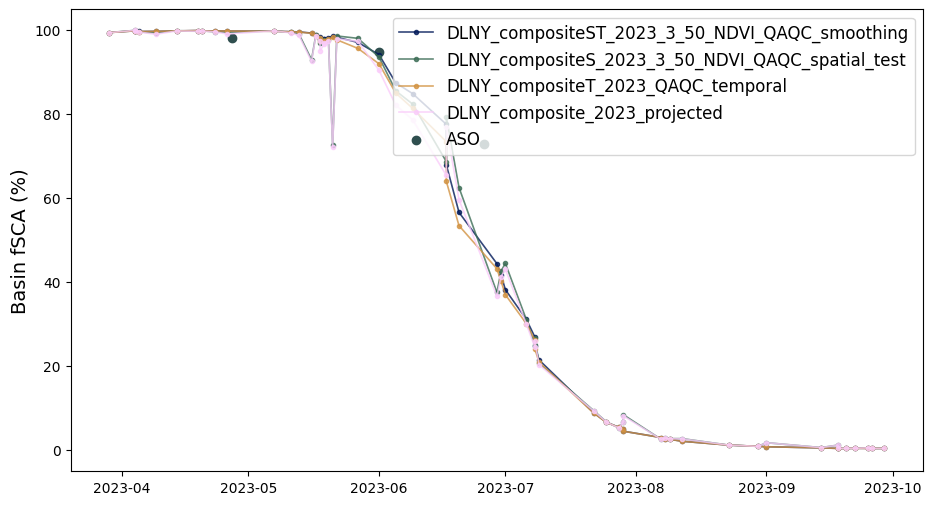

In [9]:
import cmcrameri.cm as cmc
files = sorted(glob.glob(f'/home/etboud/projects/data/stacks/*{name}*{year}*.nc'))
n_colors = len(files)
colors = [tuple(cmc.batlow(i / (n_colors - 1))) for i in range(n_colors)]
fig, ax = plt.subplots(figsize=(11, 6))
for i, file in enumerate(files):

    temp = xr.open_dataset(file)
    temp_df = create_fsca_df(temp)
    #plot on the same plot
    m_name = os.path.basename(file).split('.')[0]
    ax.plot(temp_df['date'], temp_df['fsca'], label = m_name, color = colors[i], linewidth=1.2,marker='o', markersize=3, alpha=0.8)
    # ax.scatter(temp_df['date'], temp_df['fsca'], color = 'teal', s = 3)
ax.scatter(aso_df['date'], aso_df['fsca'], label = 'ASO', color='darkslategrey')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylabel('Basin fSCA (%)', fontsize=14)
ax.set_ylim(-5, 105)



In [20]:
corr_files = pd.read_csv('/home/etboud/projects/snow_mapping/Emma/corresponding_files_all.csv') # have not tested yet
corr_fn = corr_files[corr_files['aso_date'].astype(str).str[:4]== str(year)]
# Filering down what we want to look at 
corr_fn = corr_fn[corr_fn['model_run']=='V5']
corr_fn = corr_fn[corr_fn['raw_file'].str.contains(name)]
corr_fn = corr_fn.drop(columns= ['model_file', 'model_run', 'raw_file','aso_file'])
#corr_fn.drop(index=25, inplace=True)
corr_fn = corr_fn.sort_values(by=corr_fn.columns.tolist())
corr_fn

,aso_date,ps_date
19,2022-04-05,2022-04-03
25,2022-04-05,2022-04-07
20,2022-04-29,2022-04-30
21,2022-05-18,2022-05-18


### Reprojecting MODIS

In [23]:
def reproj_fine_to_coarse(wy):
    fine_nc = f'/home/etboud/projects/data/stacks/BUDD_baseST_{wy}_3_50_NDVI_QAQC_smoothing.nc' # this changes for the year you are interested in 
    coarse_nc = '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230401_v01.0.nc'
    fine = xr.open_dataset(fine_nc)
    fine = fine.rio.write_crs('EPSG:32611')
    coarse = xr.open_dataset(coarse_nc)
    coarse = coarse.rio.write_crs(coarse.crs.proj4)
    # Reproject the fine resolution data to match the coarse resolution
    fine_projected = fine.rio.reproject_match(coarse, resampling = Resampling.average)
    # clip bounds to non nan values
    fine = fine_projected.where(~fine_projected.isnull(), drop=True)
    return fine


def read_modis_snowtoday(wy, modis_dir, start_date, end_date, fine):
    

    #mask = ~fine_forced.isnull().any(dim='time')
    
    files = glob.glob(modis_dir + f'*{wy}*nc')
    print(files)
    # select modis file between start and end dates
    dates = [i.split('/')[-1].split('_')[-2] for i in files]
    print(dates)
    files = [files[i] for i, date_str in enumerate(dates)
            if start_date <= pd.to_datetime(date_str) <= end_date]
    files.sort()
    ds_list = []
    print(files)
    sca_list = []
    for f in files[0:]:
        ds = xr.open_dataset(f,engine='netcdf4')
        ds = ds.rio.write_crs(ds.crs.proj4)
        modis_sca = ds['snow_fraction']
        # # Clip coarse to fine_reprojected extent (matching coordinates)
        modis_sca = modis_sca.rio.clip_box(*fine.rio.bounds())
        

        date_str = f.split('/')[-1].split('_')[-2]
        date = pd.to_datetime(date_str)
        
        modis_sca = modis_sca.assign_coords(time=('time', [date]))        

        sca_list.append(modis_sca)

    proj4_str = ds.rio.crs
    combine_ds_sca = xr.concat(sca_list, dim='time')
    combine_ds_sca.rio.write_crs(proj4_str, inplace=True)

    mask = ~fine.isnull().any(dim='time')
    combine_ds_sca = combine_ds_sca.where(mask)  
    combine_ds_sca = combine_ds_sca/100
    return combine_ds_sca 

def create_fsca_df(dataset):
    sca_df = []
    for t in range(len(dataset.time)):
        slice = dataset['data'].isel(time=t)
        fsca = (np.nansum(slice) / np.count_nonzero(~np.isnan(slice)))*100
        if fsca> 100:
            fsca = 100
        sca_df.append(fsca)    
    #create dataframe with fsca_list and corresponding dates
    dates = pd.to_datetime(dataset.time.values)
    df = pd.DataFrame({'date': dates, 'fsca': sca_df})
    return df

In [24]:
from rasterio.enums import Resampling

def get_fsca_df(wy, modis_dir, start_date, end_date):

    fine = reproj_fine_to_coarse(wy)
    modis_sca_ds = read_modis_snowtoday(
        wy=wateryear,
        modis_dir=modis_dir,
        start_date=start_date,
        end_date=end_date,
        fine=fine
    ) 

    modis_df = create_fsca_df(modis_sca_ds)
    planet_df = create_fsca_df(fine)
    aso_df = create_fsca_df(aso)
    # merge modis oon ps dates
    modis_df['date'] = pd.to_datetime(modis_df['date'])
    planet_df['date'] = pd.to_datetime(planet_df['date'])
    aso_df['date'] = pd.to_datetime(aso_df['date'])
    ps_merged_df = pd.merge(modis_df, planet_df, on='date', suffixes=('_modis', '_ps'))
    aso_merged_df = pd.merge(modis_df, aso_df, on='date', suffixes=('_modis', '_aso'))
    return ps_merged_df, aso_merged_df,modis_sca_ds



wateryear = 2023
modis_dir = '/data0/images/STC_MODSCG/h08v05/'
start_date = pd.to_datetime(f'{wateryear}-04-01')
end_date = pd.to_datetime(f'{wateryear+1}-09-30')
aso_nc = f'/home/etboud/projects/data/stacks/extra/BUDD_aso_projected.nc'
aso = xr.open_dataset(aso_nc)
ps_merged_df, aso_merged_df,modis_sca_ds = get_fsca_df(wateryear, modis_dir, start_date, end_date)

['/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230417_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230401_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230501_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230916_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230404_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230605_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230507_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230421_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230826_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230908_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230601_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20230504_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST

In [26]:
ps_df = []
aso_df = []
wateryears = [2022, 2023]
for wateryear in wateryears:
    modis_dir = '/data0/images/STC_MODSCG/h08v05/'
    start_date = pd.to_datetime(f'{wateryear}-04-01')
    end_date = pd.to_datetime(f'{wateryear+1}-09-30')
    aso_nc = f'/home/etboud/projects/data/stacks/extra/BUDD_aso_projected.nc'
    aso = xr.open_dataset(aso_nc)
    ps_merged_df, aso_merged_df,modis_sca_ds = get_fsca_df(wateryear, modis_dir, start_date, end_date)
    ps_df.append(ps_merged_df)
    aso_df.append(aso_merged_df)
    
# Concatenate the dataframes
ps_df = pd.concat(ps_df, ignore_index=True)
aso_df = pd.concat(aso_df, ignore_index=True)
# separate years
ps_df['year'] = ps_df['date'].dt.year
aso_df['year'] = aso_df['date'].dt.year
# Filter for the years of interest
merged_2022 = ps_df[ps_df['year'] == 2022]
merged_2023 = ps_df[ps_df['year'] == 2023]
aso_merged_2022 = aso_df[aso_df['year'] == 2022]
aso_merged_2023 = aso_df[aso_df['year'] == 2023]

['/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220102_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220919_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220809_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220210_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220810_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220129_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220902_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220629_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220509_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220331_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220308_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220303_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid
# If 'date' is not in datetime format, convert it
planet_fsca_df["date"] = pd.to_datetime(planet_fsca_df["date"], errors="coerce")

# Define seasonal start and end in MM-DD format (no year!)
season_start = (4, 1)  # April 1
season_end = (9, 29)   # September 29

# Function to convert a date to "day of season" index
def day_of_season(date):
    # Treat all dates as year-agnostic, use a reference leap-safe year
    dummy_year = 2001
    start = pd.Timestamp(f"{dummy_year}-{season_start[0]:02d}-{season_start[1]:02d}")
    current = pd.Timestamp(f"{dummy_year}-{date.month:02d}-{date.day:02d}")
    return (current - start).days

# Apply the function to both dataframes
merged_2022['day_of_season'] = merged_2022['date'].apply(day_of_season)
merged_2023['day_of_season'] = merged_2023['date'].apply(day_of_season)
aso_merged_2022['day_of_season'] = aso_merged_df['date'].apply(day_of_season)
aso_merged_2023['day_of_season'] = aso_merged_df['date'].apply(day_of_season)

# Set up shared color scale
vmin, vmax = 0, day_of_season(pd.Timestamp(f"2001-{season_end[0]:02d}-{season_end[1]:02d}"))
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cmc.batlow

# Generate colors
colors_2022 = cmap(norm(merged_2022['day_of_season']))
colors_2023 = cmap(norm(merged_2023['day_of_season']))
colors_aso_2022 = cmap(norm(aso_merged_2022['day_of_season']))
colors_aso_2023 = cmap(norm(aso_merged_2023['day_of_season']))

plt.rcParams['font.family'] = 'serif'
fig = plt.figure(figsize=(12, 12))

ax = ImageGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=.1,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.05
                )

ax[0].scatter(
    merged_2022['fsca_modis'],
    merged_2022['fsca_ps'],
    c=colors_2022,

    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)
# insert text 
ax[0].text(0.8, 0.055, '2022', transform=ax[0].transAxes, fontsize=14, fontweight='bold')
# add inset zoomed in
axins0 = ax[0].inset_axes([0.07, 0.56, 0.4, 0.4])  # [x, y, width, height]
axins0.scatter(
    merged_2022['fsca_modis'],
    merged_2022['fsca_ps'],
    c=colors_2022,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)
twin1 = ax[0].scatter(aso_merged_2022['fsca_modis'], 
                    aso_merged_2022['fsca_aso'], 
                    marker = 'd',s = 100,color=colors_aso,
                    alpha=0.8, edgecolor='k', linewidth=0.2, label = 'Lidar')
# Set limits for the inset
axins0.set_xlim(-1, 35)
axins0.set_ylim(-1, 35)
axins0.set_xticks([0, 10,20,30])
axins0.set_yticks([0, 10,20,30])
# Add grid to the inset
axins0.grid(True)
# mark where inset ins on main plot
x1, x2, y1, y2 = 0, 10, 0, 10
ax[0].indicate_inset_zoom(axins0, edgecolor="black", alpha=0.5)
# draw lines on inset
axins0.plot([0, 35], [0, 35], color='black', alpha = .5, linestyle='--')
# mark correspiing region on main plot and draw 2 lines linking two axes)


ax[1].scatter(
    merged_2023['fsca_modis'],
    merged_2023['fsca_ps'],
    c=colors_2023,

    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)
# insert text 
ax[1].text(0.8, 0.055, '2023', transform=ax[1].transAxes, fontsize=14, fontweight='bold')
# add inset zoomed in
axins1= ax[1].inset_axes([0.07, 0.56, 0.4, 0.4])  # [x, y, width, height]
axins1.scatter(
    merged_2023['fsca_modis'],
    merged_2023['fsca_ps'],
    c=colors_2023,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)


twin2 = ax[1].scatter(aso_merged_2023['fsca_modis'], 
                    aso_merged_2023['fsca_aso'], 
                    marker = 'd',s = 100,color=colors_aso,
                    alpha=0.8, edgecolor='k', linewidth=0.2, label = 'Lidar')
ax2.set_ylim(-5, 105)

# Set limits for the inset
axins1.set_xlim(-1, 35)
axins1.set_ylim(-1, 35)
axins1.set_xticks([0, 10,20,30])
axins1.set_yticks([0, 10,20,30])
# Add grid to the inset
axins1.grid(True)
# mark where inset ins on main plot
x1, x2, y1, y2 = 0, 10, 0, 10
ax[1].indicate_inset_zoom(axins1, edgecolor="black", alpha=0.5)
# draw lines on inset
axins1.plot([0, 35], [0, 35], color='black', alpha = .5, linestyle='--')
# mark correspiing region on main plot and draw 2 lines linking two axes)




# # Add colorbar to show date mapping
# sm = cm.ScalarMappable(cmap=cmc.batlow, norm=norm)
# sm.set_array([])
# # cbar = plt.colorbar(sm, ax.cbar_axes[0])
#cbar.set_label('Date')
# add 1 to 1 line
x = np.linspace(0, 100, 100)
y = x
for axis in [ax[0], ax[1]]:
    axis.plot(x, y, color='black', alpha=0.5, linestyle='--', label='1:1 Line')
    # Labeling
    axis.set_xlabel('STC-MODSCAG Basin fSCA (%)')
    axis.set_ylabel('Basin fSCA (%)')


# Create ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Add one colorbar for both plots
cbar = fig.colorbar(sm, cax=ax.cbar_axes[0], orientation='vertical')

# Set MM-DD labels for selected ticks
tick_days = [0, 75, 181]  # Approx. Apr 1, mid-June, Sept 29
tick_labels = ['04-01', '06-15', '09-29']
cbar.set_ticks(tick_days)
cbar.set_ticklabels(tick_labels)

for axis in ax:
    axis.grid(True)
    
    
# Custom legend handles with black color
custom_handles = [
    Line2D([0], [0], marker='o', markeredgecolor='k', color='white', alpha=.7, linestyle='None', label='Post-Processed'),
    Line2D([0], [0], marker='d', markeredgecolor='k', color='white', alpha=.7, linestyle='None', label='Lidar'),
    Line2D([0], [0], color='black', linestyle='--', alpha=.7, label='1:1 Line')
]
# Now pass them to the main legend
# Add the legend to the first axis in the grid
ax[0].legend(custom_handles, [h.get_label() for h in custom_handles], bbox_to_anchor=(1.4, 1.08), ncol=3, fontsize=10, frameon=False)

    
plt.tight_layout()
plt.show()